In [1]:
%load_ext autoreload
%autoreload 2

In [353]:
import numpy as np
from analysis.ngram import calculate_avg_ll
from analysis.plot_utils import plt, legend_opts, savefig
from matplotlib.animation import FuncAnimation

In [333]:
def calculate_avg_ln(prob_matrix, weights):
    return calculate_avg_ll(prob_matrix, weights, log_function=np.log)

## Combine models sequentially

In [23]:
train_prob_matrix = np.load('../data/train_prob_matrix.npy')
dev1_prob_matrix = np.load('../data/dev1_prob_matrix.npy')
dev2_prob_matrix = np.load('../data/dev2_prob_matrix.npy')

In [24]:
dev_prob_matrix = np.vstack([dev1_prob_matrix, dev2_prob_matrix])
dev_prob_matrix.shape

(803176, 6)

In [320]:
train_avg_lls = []
dev1_avg_lls = []
dev2_avg_lls = []
dev_avg_lls = []
labels = []
label = ''

ngram_combo = []
for n in range(6):
    ngram_combo.append(n)
    train_avg_lls.append(calculate_avg_ln(train_prob_matrix[:, ngram_combo]))
    dev1_avg_lls.append(calculate_avg_ln(dev1_prob_matrix[:, ngram_combo]))
    dev2_avg_lls.append(calculate_avg_ln(dev2_prob_matrix[:, ngram_combo]))
    dev_avg_lls.append(calculate_avg_ln(dev_prob_matrix[:, ngram_combo]))
    
    label += f'{n}\n'
    labels.append(label)
labels[0] = '0\n(uniform)'

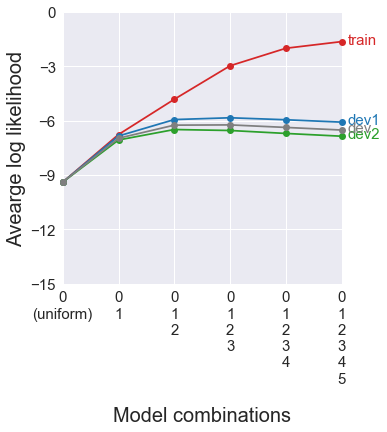

In [321]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(ngram_combo, train_avg_lls, '-o', color='tab:red', clip_on=False)
ax.plot(ngram_combo, dev1_avg_lls, '-o', color='tab:blue', clip_on=False)
ax.plot(ngram_combo, dev2_avg_lls, '-o', color='tab:green', clip_on=False)
ax.plot(ngram_combo, dev_avg_lls, '-o', color='tab:gray', clip_on=False)

ax.text(5.1, train_avg_lls[-1]+0.1, s='train', va='center', color='tab:red', fontsize=15)
ax.text(5.1, dev1_avg_lls[-1]+0.1, s='dev1', va='center', color='tab:blue', fontsize=15)
ax.text(5.1, dev2_avg_lls[-1]+0.1, s='dev2', va='center', color='tab:green', fontsize=15)
ax.text(5.1, dev_avg_lls[-1]+0.1, s='dev', va='center', color='tab:gray', fontsize=15)

ax.set_xticklabels(labels)
ax.set_xlabel('Model combinations')
ax.set_ylabel('Avearge log likelihood')
ax.set_xlim(0, 5)
ax.set_ylim(-15, 0)
ax.set_yticks(range(-15, 1, 3))
plt.show()

## Interpolating 2 models

In [322]:
unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
dev1_avg_lls = []
dev2_avg_lls = []
dev_avg_lls = []

for unigram_weight in unigram_weights:
    dev1_avg_lls.append(calculate_avg_ln(dev1_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))
    dev2_avg_lls.append(calculate_avg_ln(dev2_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))
    dev_avg_lls.append(calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))

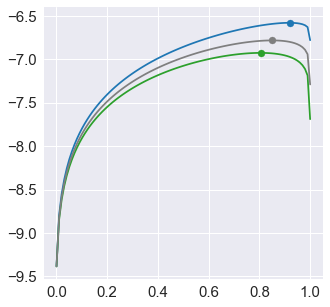

In [323]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(unigram_weights, dev1_avg_lls, color='tab:blue', clip_on=False)
ax.plot(unigram_weights, dev2_avg_lls, color='tab:green', clip_on=False)
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)

ax.scatter(unigram_weights[np.argmax(dev1_avg_lls)], np.max(dev1_avg_lls), color='tab:blue', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev2_avg_lls)], np.max(dev2_avg_lls), color='tab:green', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev_avg_lls)], np.max(dev_avg_lls), color='tab:gray', clip_on=False)

## Gradient descent

In [324]:
class GradientDescent:
    def __init__(self, track_iteration=True):
        self.track_iteration = track_iteration
        
    def fit(self, prob_matrix, learning_rate, n_iter=100):
        if self.track_iteration:
            self.tracked_info = {}
            
        n_models = prob_matrix.shape[1]
        self.weights = np.ones(n_models) / n_models

        uniform_prob = prob_matrix[:, [0]]
        ngram_probs = prob_matrix[:, 1:]
        for iteration in range(n_iter):
            interpolated_probs = np.sum(prob_matrix * self.weights, axis=1, keepdims=True)
            gradients = np.mean((ngram_probs - uniform_prob) / interpolated_probs, axis=0)
            if self.track_iteration:
                self.tracked_info[iteration] = {'weights': self.weights.copy(),
                                                'gradients': gradients,
                                                'avg_ll': calculate_avg_ln(prob_matrix, self.weights)}
            self.weights[1:] += learning_rate * gradients
            self.weights[0] = 1 - self.weights[1:].sum()

In [395]:
n_iter = 11
gd = GradientDescent()
gd.fit(dev_prob_matrix[:, :2], learning_rate=0.1, n_iter=n_iter)
gd.weights

array([0.15013842, 0.84986158])

In [413]:
def update(fig, ax, iteration):
    fig.suptitle(f'Iteration {iteration}', fontsize=20)
    ax.lines = [ax.lines[0]]
    ax.collections = []
        
    tangent_length = 0.15
    
    info = gd.tracked_info[iteration]
    unigram_weight = info['weights'][1]
    unigram_gradient = info['gradients'][0]
    avg_ll = info['avg_ll']
    lower_unigram_weight, upper_unigram_weight = unigram_weight - tangent_length, unigram_weight + tangent_length
    lower_ll, upper_ll = avg_ll - unigram_gradient * tangent_length, avg_ll + unigram_gradient * tangent_length
    ax.plot([lower_unigram_weight, upper_unigram_weight], [lower_ll, upper_ll], color='tab:orange')
    ax.vlines(unigram_weight, -10, avg_ll, colors='tab:orange', linestyles='dashed', linewidth=0.5)
    ax.scatter(unigram_weight, avg_ll, color='tab:orange')

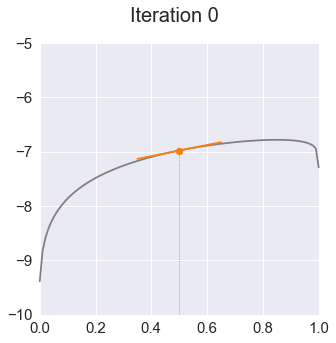

In [417]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)
ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)

anim = FuncAnimation(fig, lambda iteration: update(fig, ax, iteration), 
                     frames=range(n_iter), interval=200, repeat=True)
anim.save('../viz/gradient_descent.mp4', writer='ffmpeg')

## Expectation-maximation algorithm

### E-step

Log likelihood vs lower bound of average likelihood for first word in combined `dev` set

In [9]:
def calculate_lower_bound_ll(word_probs, true_weights, posterior_weights):
    with np.errstate(invalid='ignore'):
        lower_bound_components = posterior_weights * np.log2(word_probs * true_weights / posterior_weights)
        lower_bound_components[np.isnan(lower_bound_components)] = 0
        lower_bound_ll = np.sum(lower_bound_components)
    return lower_bound_ll

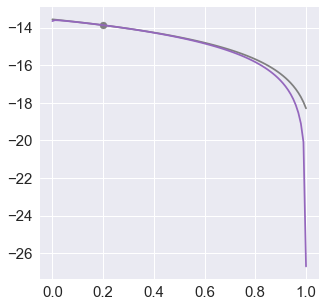

In [10]:
first_word_probs = dev_prob_matrix[[0], :2]
unigram_step_weight = 0.2
joint_probs = first_word_probs * [1 - unigram_step_weight, unigram_step_weight]
marginal_prob = np.sum(joint_probs)
posterior_weights = joint_probs / marginal_prob

first_word_lls = []
first_word_lower_bound_lls = []

unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
for unigram_weight in unigram_weights:
    first_word_ll = calculate_avg_ll(first_word_probs, weights=[1-unigram_weight, unigram_weight])
    first_word_lls.append(first_word_ll)
    
    first_word_lower_bound_ll = calculate_lower_bound_ll(first_word_probs,
                                                         true_weights=[1-unigram_weight, unigram_weight],
                                                         posterior_weights=posterior_weights)
    first_word_lower_bound_lls.append(first_word_lower_bound_ll)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, first_word_lls, color='tab:gray', clip_on=False)
ax.plot(unigram_weights, first_word_lower_bound_lls, color='tab:purple', clip_on=False)
ax.scatter(unigram_step_weight, calculate_avg_ll(first_word_probs, weights=[1-unigram_step_weight, unigram_step_weight]), color='tab:gray', clip_on=False)

Average log likelihood vs lower bound of average likelihood for all words in combined `dev` set

In [11]:
def calculate_posterior_weights(prob_matrix, unigram_step_weight):
    joint_probs = prob_matrix * [1 - unigram_step_weight, unigram_step_weight]
    marginal_probs = np.sum(joint_probs, axis=1, keepdims=True)
    posterior_weights = joint_probs / marginal_probs
    return posterior_weights

In [12]:
def calculate_lower_bound_avg_ll(prob_matrix, true_weights, posterior_weights):
    with np.errstate(invalid='ignore'):
        lower_bound_components = posterior_weights * np.log2(prob_matrix * true_weights / posterior_weights)
        lower_bound_components[np.isnan(lower_bound_components)] = 0
        lower_bound_ll = np.sum(lower_bound_components, axis=1)
        lower_bound_avg_ll = lower_bound_ll.mean()
    return lower_bound_avg_ll

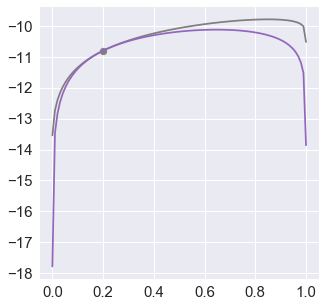

In [13]:
dev_avg_lls = []
dev_lower_bound_avg_lls = []

unigram_step_weight = 0.2
unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
posterior_weights = calculate_posterior_weights(dev_prob_matrix[:, [0, 1]], unigram_step_weight)

for unigram_weight in unigram_weights:
    dev_avg_ll = calculate_avg_ll(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight])
    dev_avg_lls.append(dev_avg_ll)
    
    dev_lower_bound_avg_ll = calculate_lower_bound_avg_ll(dev_prob_matrix[:, [0, 1]],
                                                         true_weights=[1-unigram_weight, unigram_weight],
                                                         posterior_weights=posterior_weights)
    dev_lower_bound_avg_lls.append(dev_lower_bound_avg_ll)
    
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)
ax.plot(unigram_weights, dev_lower_bound_avg_lls, color='tab:purple', clip_on=False)
ax.scatter(unigram_step_weight, calculate_avg_ll(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_step_weight, unigram_step_weight]), color='tab:gray', clip_on=False)

### EM algorithm

In [14]:
def get_em_weights(prob_matrix, n_iter=50):
    n_models = prob_matrix.shape[1]
    weights = np.ones(n_models) / n_models

    for i in range(n_iter):
        weighted_probs = prob_matrix * weights
        total_probs = weighted_probs.sum(axis=1, keepdims=True)

        # E-step
        posterior_weights = weighted_probs / total_probs

        # M-step
        weights = posterior_weights.mean(axis=0)
    return weights

In [71]:
dev_weights = get_em_weights(dev_prob_matrix)

Average log likelihood vs lower bound of average likelihood for all words in combined `dev` set

In [17]:
def calculate_posterior_weights(prob_matrix, unigram_step_weight):
    joint_probs = prob_matrix * [1 - unigram_step_weight, unigram_step_weight]
    marginal_probs = np.sum(joint_probs, axis=1, keepdims=True)
    posterior_weights = joint_probs / marginal_probs
    return posterior_weights

In [18]:
def calculate_lower_bound_avg_ll(prob_matrix, true_weights, posterior_weights):
    with np.errstate(invalid='ignore'):
        lower_bound_components = posterior_weights * np.log2(prob_matrix * true_weights / posterior_weights)
        lower_bound_components[np.isnan(lower_bound_components)] = 0
        lower_bound_ll = np.sum(lower_bound_components, axis=1)
        lower_bound_avg_ll = lower_bound_ll.mean()
    return lower_bound_avg_ll

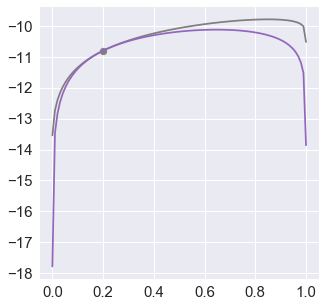

In [19]:
dev_avg_lls = []
dev_lower_bound_avg_lls = []

unigram_step_weight = 0.2
unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
posterior_weights = calculate_posterior_weights(dev_prob_matrix[:, [0, 1]], unigram_step_weight)

for unigram_weight in unigram_weights:
    dev_avg_ll = calculate_avg_ll(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight])
    dev_avg_lls.append(dev_avg_ll)
    
    dev_lower_bound_avg_ll = calculate_lower_bound_avg_ll(dev_prob_matrix[:, [0, 1]],
                                                         true_weights=[1-unigram_weight, unigram_weight],
                                                         posterior_weights=posterior_weights)
    dev_lower_bound_avg_lls.append(dev_lower_bound_avg_ll)
    
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)
ax.plot(unigram_weights, dev_lower_bound_avg_lls, color='tab:purple', clip_on=False)
ax.scatter(unigram_step_weight, calculate_avg_ll(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_step_weight, unigram_step_weight]), color='tab:gray', clip_on=False)

### EM algorithm

In [21]:
dev_weights = get_em_weights(dev_prob_matrix[:, [0, 1]])

In [22]:
dev_weights

array([0.14949361, 0.85050639])